In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%bash
pip install tqdm
pip install --upgrade torch
pip install numpy
pip install matplotlib

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0)


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os

import torch
import torchvision

from data_utils import cifar10, cifar10_classes, matplotlib_imshow, plot_history
from train_utils import train, evaluate, device
from models.mlp import MLP

In [3]:
HPS = dict(
    batch_size=32,
    epochs=50,
)

model_dir = './models/cifar10_gn_ws_resnet'

train_ds, test_ds = cifar10(batch_size=HPS['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.utils import load_state_dict_from_url


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

class WeightStdConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(WeightStdConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return WeightStdConv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return WeightStdConv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, group_factor=4):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.GroupNorm
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes//group_factor, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes//group_factor, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, group_factor=4):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.GroupNorm
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width//group_factor, width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width//group_factor, width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer((planes * self.expansion)//group_factor, planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, group_factor=4):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.GroupNorm
        self._norm_layer = norm_layer

        self.group_factor = group_factor
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = WeightStdConv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes//self.group_factor, self.inplanes)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, WeightStdConv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer((planes * block.expansion)//self.group_factor, planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

# Custom added
def resnet9(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet9', BasicBlock, [1, 1, 1, 1], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [8]:
model = resnet18(num_classes=10, zero_init_residual=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=HPS['epochs'])
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, model_dir)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.6234590272375657 Batch Accuracy: 0.39486


  2%|▏         | 1/50 [01:25<1:09:43, 85.37s/it]

Test Set evaluation: Loss: 1.2272661200727517 Test Accuracy: 0.5459
Epoch 1: Loss: 1.08246811707662 Batch Accuracy: 0.61526


  4%|▍         | 2/50 [02:52<1:08:36, 85.77s/it]

Test Set evaluation: Loss: 0.9471278344861235 Test Accuracy: 0.6537
Epoch 2: Loss: 0.8666934018247949 Batch Accuracy: 0.69582


  6%|▌         | 3/50 [04:18<1:07:25, 86.07s/it]

Test Set evaluation: Loss: 0.7602051519357358 Test Accuracy: 0.7278
Epoch 3: Loss: 0.7494992261617823 Batch Accuracy: 0.74208


  8%|▊         | 4/50 [05:45<1:06:05, 86.21s/it]

Test Set evaluation: Loss: 0.6970345866375457 Test Accuracy: 0.7633
Epoch 4: Loss: 0.6738994854787795 Batch Accuracy: 0.7684


 10%|█         | 5/50 [07:12<1:04:52, 86.49s/it]

Test Set evaluation: Loss: 0.6565631262410563 Test Accuracy: 0.7778
Epoch 5: Loss: 0.6319539570038089 Batch Accuracy: 0.78452


 12%|█▏        | 6/50 [08:39<1:03:25, 86.50s/it]

Test Set evaluation: Loss: 0.5793763507669345 Test Accuracy: 0.7998
Epoch 6: Loss: 0.6044031058128874 Batch Accuracy: 0.79262


 14%|█▍        | 7/50 [10:06<1:02:12, 86.81s/it]

Test Set evaluation: Loss: 0.5664664397890956 Test Accuracy: 0.8062
Epoch 7: Loss: 0.5785927813040165 Batch Accuracy: 0.8041


 16%|█▌        | 8/50 [11:33<1:00:50, 86.91s/it]

Test Set evaluation: Loss: 0.5951385687048824 Test Accuracy: 0.7984
Epoch 8: Loss: 0.5640548118416956 Batch Accuracy: 0.80902


 18%|█▊        | 9/50 [13:00<59:24, 86.93s/it]  

Test Set evaluation: Loss: 0.5879998879310803 Test Accuracy: 0.8001
Epoch 9: Loss: 0.5463521018366896 Batch Accuracy: 0.81444


 20%|██        | 10/50 [14:27<57:56, 86.90s/it]

Test Set evaluation: Loss: 0.5282053610625358 Test Accuracy: 0.8215
Epoch 10: Loss: 0.5342651821734885 Batch Accuracy: 0.81922


 22%|██▏       | 11/50 [15:54<56:26, 86.83s/it]

Test Set evaluation: Loss: 0.5109515225354094 Test Accuracy: 0.8263
Epoch 11: Loss: 0.5281385985880576 Batch Accuracy: 0.82194


 24%|██▍       | 12/50 [17:20<54:57, 86.79s/it]

Test Set evaluation: Loss: 0.5343068889535654 Test Accuracy: 0.816
Epoch 12: Loss: 0.514434838535232 Batch Accuracy: 0.82576


 26%|██▌       | 13/50 [18:47<53:30, 86.78s/it]

Test Set evaluation: Loss: 0.5564171454776972 Test Accuracy: 0.8077
Epoch 13: Loss: 0.5084739506616474 Batch Accuracy: 0.82722


 28%|██▊       | 14/50 [20:16<52:23, 87.32s/it]

Test Set evaluation: Loss: 0.6228604939894173 Test Accuracy: 0.7949
Epoch 14: Loss: 0.49980389714355433 Batch Accuracy: 0.83048


 30%|███       | 15/50 [21:42<50:47, 87.06s/it]

Test Set evaluation: Loss: 0.48447321802853777 Test Accuracy: 0.8365
Epoch 15: Loss: 0.496012686148181 Batch Accuracy: 0.83182


 32%|███▏      | 16/50 [23:09<49:16, 86.95s/it]

Test Set evaluation: Loss: 0.5094222872021099 Test Accuracy: 0.8298
Epoch 16: Loss: 0.48811615236527783 Batch Accuracy: 0.83568


 34%|███▍      | 17/50 [24:36<47:49, 86.95s/it]

Test Set evaluation: Loss: 0.5019639533834336 Test Accuracy: 0.8374
Epoch 17: Loss: 0.4896107407874277 Batch Accuracy: 0.83442


 36%|███▌      | 18/50 [26:02<46:19, 86.85s/it]

Test Set evaluation: Loss: 0.4494179941166323 Test Accuracy: 0.8494
Epoch 18: Loss: 0.4825256394886162 Batch Accuracy: 0.83704


 38%|███▊      | 19/50 [27:29<44:48, 86.73s/it]

Test Set evaluation: Loss: 0.5787471932725022 Test Accuracy: 0.8086
Epoch 19: Loss: 0.4862530501231656 Batch Accuracy: 0.83648


 40%|████      | 20/50 [28:55<43:19, 86.63s/it]

Test Set evaluation: Loss: 0.5948709147616317 Test Accuracy: 0.801
Epoch 20: Loss: 0.47686065128043303 Batch Accuracy: 0.8401


 42%|████▏     | 21/50 [30:22<41:53, 86.66s/it]

Test Set evaluation: Loss: 0.5347204085546561 Test Accuracy: 0.8255
Epoch 21: Loss: 0.4718210808289257 Batch Accuracy: 0.84158


 44%|████▍     | 22/50 [31:49<40:25, 86.63s/it]

Test Set evaluation: Loss: 0.5100061670183754 Test Accuracy: 0.8258
Epoch 22: Loss: 0.47930491714239576 Batch Accuracy: 0.83842


 46%|████▌     | 23/50 [33:15<38:57, 86.59s/it]

Test Set evaluation: Loss: 0.5422995077630582 Test Accuracy: 0.8187
Epoch 23: Loss: 0.4700849815554826 Batch Accuracy: 0.84022


 48%|████▊     | 24/50 [34:41<37:26, 86.41s/it]

Test Set evaluation: Loss: 0.42015124126649894 Test Accuracy: 0.8588
Epoch 24: Loss: 0.47008947066138057 Batch Accuracy: 0.84202


 50%|█████     | 25/50 [36:06<35:52, 86.10s/it]

Test Set evaluation: Loss: 0.48488024662668333 Test Accuracy: 0.8384
Epoch 25: Loss: 0.25035267532162575 Batch Accuracy: 0.91584


 52%|█████▏    | 26/50 [37:33<34:28, 86.21s/it]

Test Set evaluation: Loss: 0.288952525717001 Test Accuracy: 0.9018
Epoch 26: Loss: 0.19709346572834563 Batch Accuracy: 0.93266


 54%|█████▍    | 27/50 [38:59<33:05, 86.31s/it]

Test Set evaluation: Loss: 0.2754797700483102 Test Accuracy: 0.9076
Epoch 27: Loss: 0.17151517884880876 Batch Accuracy: 0.94104


 56%|█████▌    | 28/50 [40:26<31:42, 86.49s/it]

Test Set evaluation: Loss: 0.25924275576854094 Test Accuracy: 0.9125
Epoch 28: Loss: 0.1533009219805633 Batch Accuracy: 0.94788


 58%|█████▊    | 29/50 [41:53<30:15, 86.47s/it]

Test Set evaluation: Loss: 0.2767712215717418 Test Accuracy: 0.9092
Epoch 29: Loss: 0.14229353571844527 Batch Accuracy: 0.95126


 60%|██████    | 30/50 [43:20<28:51, 86.60s/it]

Test Set evaluation: Loss: 0.26880621628318063 Test Accuracy: 0.9135
Epoch 30: Loss: 0.1335771577736638 Batch Accuracy: 0.95394


 62%|██████▏   | 31/50 [44:46<27:25, 86.60s/it]

Test Set evaluation: Loss: 0.2662710148421601 Test Accuracy: 0.9156
Epoch 31: Loss: 0.1269396483690805 Batch Accuracy: 0.95712


 64%|██████▍   | 32/50 [46:13<25:59, 86.63s/it]

Test Set evaluation: Loss: 0.26994065942909246 Test Accuracy: 0.9116
Epoch 32: Loss: 0.11820713905987025 Batch Accuracy: 0.95984


 66%|██████▌   | 33/50 [47:40<24:32, 86.65s/it]

Test Set evaluation: Loss: 0.27640760092499156 Test Accuracy: 0.915
Epoch 33: Loss: 0.11396955352417186 Batch Accuracy: 0.96196


 68%|██████▊   | 34/50 [49:07<23:07, 86.73s/it]

Test Set evaluation: Loss: 0.28175022612852507 Test Accuracy: 0.914
Epoch 34: Loss: 0.11428049826200262 Batch Accuracy: 0.961


 70%|███████   | 35/50 [50:33<21:41, 86.76s/it]

Test Set evaluation: Loss: 0.26339712101347246 Test Accuracy: 0.916
Epoch 35: Loss: 0.1147040799934946 Batch Accuracy: 0.96026


 72%|███████▏  | 36/50 [52:00<20:14, 86.77s/it]

Test Set evaluation: Loss: 0.2878178209482957 Test Accuracy: 0.9104
Epoch 36: Loss: 0.1128592814619147 Batch Accuracy: 0.9613


 74%|███████▍  | 37/50 [53:27<18:49, 86.87s/it]

Test Set evaluation: Loss: 0.2743320598693999 Test Accuracy: 0.9133
Epoch 37: Loss: 0.11137453817612875 Batch Accuracy: 0.96214


 76%|███████▌  | 38/50 [54:54<17:22, 86.87s/it]

Test Set evaluation: Loss: 0.29616470668857664 Test Accuracy: 0.9076
Epoch 38: Loss: 0.11326533901968153 Batch Accuracy: 0.9602


 78%|███████▊  | 39/50 [56:21<15:55, 86.87s/it]

Test Set evaluation: Loss: 0.31353343821490726 Test Accuracy: 0.9014
Epoch 39: Loss: 0.11108618043139648 Batch Accuracy: 0.9614


 80%|████████  | 40/50 [57:48<14:28, 86.82s/it]

Test Set evaluation: Loss: 0.30237666391336115 Test Accuracy: 0.9044
Epoch 40: Loss: 0.056794369356112075 Batch Accuracy: 0.98186


 82%|████████▏ | 41/50 [59:14<13:00, 86.70s/it]

Test Set evaluation: Loss: 0.22957290554666124 Test Accuracy: 0.9309
Epoch 41: Loss: 0.04072444734219593 Batch Accuracy: 0.98734


 84%|████████▍ | 42/50 [1:00:41<11:32, 86.59s/it]

Test Set evaluation: Loss: 0.2357928648965951 Test Accuracy: 0.9302
Epoch 42: Loss: 0.03449025375121145 Batch Accuracy: 0.9894


 86%|████████▌ | 43/50 [1:02:06<10:03, 86.26s/it]

Test Set evaluation: Loss: 0.2285860328765485 Test Accuracy: 0.9331
Epoch 43: Loss: 0.02867066902676043 Batch Accuracy: 0.99118


 88%|████████▊ | 44/50 [1:03:32<08:37, 86.27s/it]

Test Set evaluation: Loss: 0.23805439367052764 Test Accuracy: 0.9323
Epoch 44: Loss: 0.02605838166475022 Batch Accuracy: 0.99202


 90%|█████████ | 45/50 [1:04:59<07:12, 86.48s/it]

Test Set evaluation: Loss: 0.24230605044819492 Test Accuracy: 0.9329
Epoch 45: Loss: 0.022902268791611183 Batch Accuracy: 0.99306


 92%|█████████▏| 46/50 [1:06:26<05:46, 86.57s/it]

Test Set evaluation: Loss: 0.2449961232364374 Test Accuracy: 0.9345
Epoch 46: Loss: 0.019331528674480424 Batch Accuracy: 0.99402


 94%|█████████▍| 47/50 [1:07:53<04:20, 86.71s/it]

Test Set evaluation: Loss: 0.25432157796824695 Test Accuracy: 0.9321
Epoch 47: Loss: 0.018979230128343814 Batch Accuracy: 0.99434


 96%|█████████▌| 48/50 [1:09:20<02:53, 86.72s/it]

Test Set evaluation: Loss: 0.2543717529948283 Test Accuracy: 0.9342
Epoch 48: Loss: 0.017391532965837748 Batch Accuracy: 0.9948


 98%|█████████▊| 49/50 [1:10:47<01:26, 86.85s/it]

Test Set evaluation: Loss: 0.2566965310553538 Test Accuracy: 0.9344
Epoch 49: Loss: 0.01546821857855303 Batch Accuracy: 0.99562


100%|██████████| 50/50 [1:12:14<00:00, 86.68s/it]

Test Set evaluation: Loss: 0.26529005330525335 Test Accuracy: 0.9327


Test Set evaluation: Loss: 0.26529005330525335 Test Accuracy: 0.9327


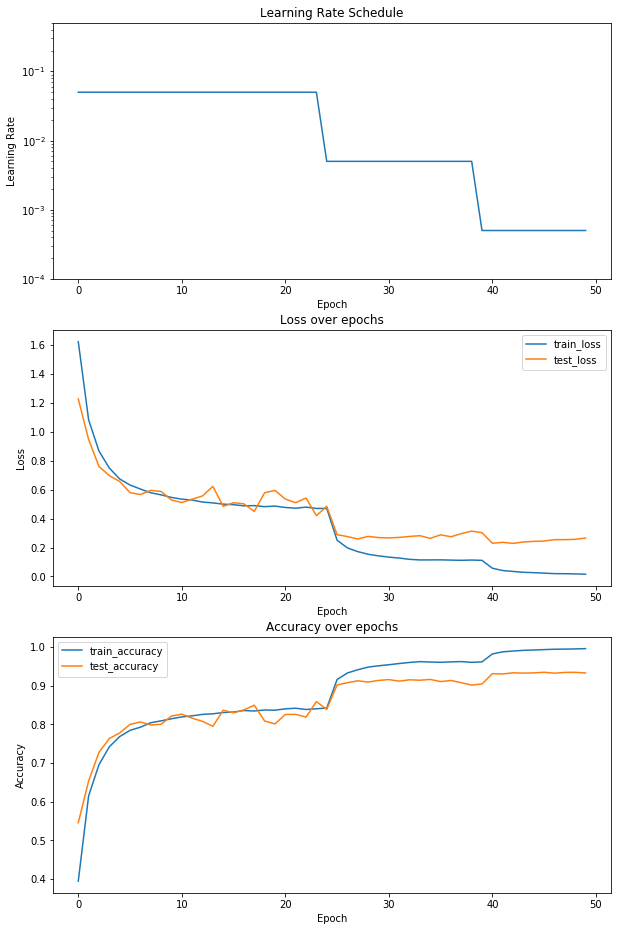

In [5]:
checkpoint = torch.load(model_dir)
r18 = resnet18(num_classes=10, zero_init_residual=True)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'], figname='messing_with_normalization.png')

In [6]:
model = resnet9(num_classes=10, zero_init_residual=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=HPS['epochs'])
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_resnet9')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.6694320034919758 Batch Accuracy: 0.3786


  2%|▏         | 1/50 [00:51<42:05, 51.54s/it]

Test Set evaluation: Loss: 1.368666285333542 Test Accuracy: 0.4977
Epoch 1: Loss: 1.1329856252944859 Batch Accuracy: 0.59222


  4%|▍         | 2/50 [01:43<41:19, 51.66s/it]

Test Set evaluation: Loss: 1.0700698453016555 Test Accuracy: 0.6273
Epoch 2: Loss: 0.8928777421809738 Batch Accuracy: 0.68566


  6%|▌         | 3/50 [02:39<41:26, 52.91s/it]

Test Set evaluation: Loss: 0.8223603005035998 Test Accuracy: 0.7071
Epoch 3: Loss: 0.7588460016959917 Batch Accuracy: 0.73786


  8%|▊         | 4/50 [03:33<40:55, 53.38s/it]

Test Set evaluation: Loss: 0.7058716028833542 Test Accuracy: 0.7572
Epoch 4: Loss: 0.690538180356825 Batch Accuracy: 0.76082


 10%|█         | 5/50 [04:25<39:43, 52.98s/it]

Test Set evaluation: Loss: 0.663075147773892 Test Accuracy: 0.7662
Epoch 5: Loss: 0.6447021048933134 Batch Accuracy: 0.77792


 12%|█▏        | 6/50 [05:16<38:22, 52.33s/it]

Test Set evaluation: Loss: 0.6921282588197781 Test Accuracy: 0.7629
Epoch 6: Loss: 0.6099751766435015 Batch Accuracy: 0.79182


 14%|█▍        | 7/50 [06:07<37:10, 51.88s/it]

Test Set evaluation: Loss: 0.6640474619671178 Test Accuracy: 0.7755
Epoch 7: Loss: 0.5890987839309054 Batch Accuracy: 0.7986


 16%|█▌        | 8/50 [06:58<36:07, 51.61s/it]

Test Set evaluation: Loss: 0.632740519536189 Test Accuracy: 0.7869
Epoch 8: Loss: 0.570157616839566 Batch Accuracy: 0.80556


 18%|█▊        | 9/50 [07:49<35:10, 51.49s/it]

Test Set evaluation: Loss: 0.597521920887807 Test Accuracy: 0.793
Epoch 9: Loss: 0.558470937489548 Batch Accuracy: 0.8087


 20%|██        | 10/50 [08:40<34:13, 51.35s/it]

Test Set evaluation: Loss: 0.524205772021708 Test Accuracy: 0.8254
Epoch 10: Loss: 0.5446924564314819 Batch Accuracy: 0.81464


 22%|██▏       | 11/50 [09:31<33:16, 51.20s/it]

Test Set evaluation: Loss: 0.6220793272264469 Test Accuracy: 0.7881
Epoch 11: Loss: 0.5364053988744644 Batch Accuracy: 0.8169


 24%|██▍       | 12/50 [10:22<32:25, 51.20s/it]

Test Set evaluation: Loss: 0.5476493555040786 Test Accuracy: 0.8126
Epoch 12: Loss: 0.5281176596346072 Batch Accuracy: 0.82006


 26%|██▌       | 13/50 [11:13<31:29, 51.07s/it]

Test Set evaluation: Loss: 0.5448284038482383 Test Accuracy: 0.8136
Epoch 13: Loss: 0.5213344258828874 Batch Accuracy: 0.82266


 28%|██▊       | 14/50 [12:04<30:34, 50.95s/it]

Test Set evaluation: Loss: 0.5106455726793018 Test Accuracy: 0.8284
Epoch 14: Loss: 0.5183900013871096 Batch Accuracy: 0.82374


 30%|███       | 15/50 [12:55<29:46, 51.03s/it]

Test Set evaluation: Loss: 0.4884100768703241 Test Accuracy: 0.8367
Epoch 15: Loss: 0.5103725975740436 Batch Accuracy: 0.82722


 32%|███▏      | 16/50 [13:46<28:57, 51.10s/it]

Test Set evaluation: Loss: 0.5493044220030118 Test Accuracy: 0.8153
Epoch 16: Loss: 0.5069950899003182 Batch Accuracy: 0.82834


 34%|███▍      | 17/50 [14:37<28:03, 51.02s/it]

Test Set evaluation: Loss: 0.5027389049339599 Test Accuracy: 0.8294
Epoch 17: Loss: 0.5053724920661954 Batch Accuracy: 0.82812


 36%|███▌      | 18/50 [15:28<27:11, 50.99s/it]

Test Set evaluation: Loss: 0.5848129066034627 Test Accuracy: 0.7996
Epoch 18: Loss: 0.4967129676676071 Batch Accuracy: 0.83114


 38%|███▊      | 19/50 [16:19<26:20, 50.97s/it]

Test Set evaluation: Loss: 0.47526436106275066 Test Accuracy: 0.8419
Epoch 19: Loss: 0.5002593431414432 Batch Accuracy: 0.82952


 40%|████      | 20/50 [17:10<25:30, 51.01s/it]

Test Set evaluation: Loss: 0.5089519287164981 Test Accuracy: 0.8268
Epoch 20: Loss: 0.49273015193579217 Batch Accuracy: 0.8332


 42%|████▏     | 21/50 [18:01<24:40, 51.07s/it]

Test Set evaluation: Loss: 0.5489690777973626 Test Accuracy: 0.8167
Epoch 21: Loss: 0.49086375959737133 Batch Accuracy: 0.83216


 44%|████▍     | 22/50 [18:52<23:45, 50.90s/it]

Test Set evaluation: Loss: 0.5356499930254568 Test Accuracy: 0.8185
Epoch 22: Loss: 0.4974982726959105 Batch Accuracy: 0.83204


 46%|████▌     | 23/50 [19:43<22:56, 50.99s/it]

Test Set evaluation: Loss: 0.5513991281247368 Test Accuracy: 0.8197
Epoch 23: Loss: 0.4869567951424642 Batch Accuracy: 0.83518


 48%|████▊     | 24/50 [20:34<22:05, 50.97s/it]

Test Set evaluation: Loss: 0.5061968003218167 Test Accuracy: 0.8273
Epoch 24: Loss: 0.48790614428481305 Batch Accuracy: 0.83352


 50%|█████     | 25/50 [21:25<21:15, 51.00s/it]

Test Set evaluation: Loss: 0.47430703686639525 Test Accuracy: 0.8377
Epoch 25: Loss: 0.27713269968794196 Batch Accuracy: 0.90526


 52%|█████▏    | 26/50 [22:16<20:25, 51.05s/it]

Test Set evaluation: Loss: 0.3235457723561567 Test Accuracy: 0.891
Epoch 26: Loss: 0.22734643879298286 Batch Accuracy: 0.92198


 54%|█████▍    | 27/50 [23:07<19:34, 51.04s/it]

Test Set evaluation: Loss: 0.2913311090403662 Test Accuracy: 0.8997
Epoch 27: Loss: 0.20023959566811034 Batch Accuracy: 0.9323


 56%|█████▌    | 28/50 [23:58<18:41, 50.97s/it]

Test Set evaluation: Loss: 0.3012056144091268 Test Accuracy: 0.901
Epoch 28: Loss: 0.18219473238162082 Batch Accuracy: 0.93822


 58%|█████▊    | 29/50 [24:49<17:51, 51.05s/it]

Test Set evaluation: Loss: 0.2718717829285624 Test Accuracy: 0.907
Epoch 29: Loss: 0.17067520063482486 Batch Accuracy: 0.94262


 60%|██████    | 30/50 [25:40<17:00, 51.01s/it]

Test Set evaluation: Loss: 0.28281410907308896 Test Accuracy: 0.9076
Epoch 30: Loss: 0.16215372159099892 Batch Accuracy: 0.94416


 62%|██████▏   | 31/50 [26:31<16:09, 51.05s/it]

Test Set evaluation: Loss: 0.2733743988548795 Test Accuracy: 0.9089
Epoch 31: Loss: 0.15339771586917794 Batch Accuracy: 0.94716


 64%|██████▍   | 32/50 [27:22<15:18, 51.00s/it]

Test Set evaluation: Loss: 0.2748709639218954 Test Accuracy: 0.909
Epoch 32: Loss: 0.14384451365278306 Batch Accuracy: 0.95204


 66%|██████▌   | 33/50 [28:13<14:27, 51.05s/it]

Test Set evaluation: Loss: 0.27030114942310624 Test Accuracy: 0.9112
Epoch 33: Loss: 0.14038837291193043 Batch Accuracy: 0.95174


 68%|██████▊   | 34/50 [29:04<13:35, 50.98s/it]

Test Set evaluation: Loss: 0.3039601003221525 Test Accuracy: 0.9053
Epoch 34: Loss: 0.13779984458730396 Batch Accuracy: 0.95228


 70%|███████   | 35/50 [29:55<12:44, 50.95s/it]

Test Set evaluation: Loss: 0.276572518482114 Test Accuracy: 0.9107
Epoch 35: Loss: 0.1323277704106073 Batch Accuracy: 0.95512


 72%|███████▏  | 36/50 [30:47<11:57, 51.26s/it]

Test Set evaluation: Loss: 0.3157769204013216 Test Accuracy: 0.8957
Epoch 36: Loss: 0.13644819827041257 Batch Accuracy: 0.95294


 74%|███████▍  | 37/50 [31:40<11:14, 51.89s/it]

Test Set evaluation: Loss: 0.2646198603696526 Test Accuracy: 0.9154
Epoch 37: Loss: 0.12930830073485095 Batch Accuracy: 0.95552


 76%|███████▌  | 38/50 [32:33<10:27, 52.30s/it]

Test Set evaluation: Loss: 0.2886309201915424 Test Accuracy: 0.9078
Epoch 38: Loss: 0.12967627939380233 Batch Accuracy: 0.95416


 78%|███████▊  | 39/50 [33:27<09:37, 52.52s/it]

Test Set evaluation: Loss: 0.2970137371184727 Test Accuracy: 0.9038
Epoch 39: Loss: 0.12915780055452847 Batch Accuracy: 0.95556


 80%|████████  | 40/50 [34:20<08:46, 52.69s/it]

Test Set evaluation: Loss: 0.292784395410468 Test Accuracy: 0.9065
Epoch 40: Loss: 0.07634897759006676 Batch Accuracy: 0.9759


 82%|████████▏ | 41/50 [35:13<07:56, 52.93s/it]

Test Set evaluation: Loss: 0.23159086537925294 Test Accuracy: 0.9277
Epoch 41: Loss: 0.06303937967627721 Batch Accuracy: 0.98048


 84%|████████▍ | 42/50 [36:06<07:03, 52.97s/it]

Test Set evaluation: Loss: 0.23250736892758944 Test Accuracy: 0.925
Epoch 42: Loss: 0.054648241696590875 Batch Accuracy: 0.98388


 86%|████████▌ | 43/50 [37:00<06:12, 53.23s/it]

Test Set evaluation: Loss: 0.23396346269371793 Test Accuracy: 0.9267
Epoch 43: Loss: 0.05023707048812558 Batch Accuracy: 0.98466


 88%|████████▊ | 44/50 [37:53<05:18, 53.14s/it]

Test Set evaluation: Loss: 0.23716210388837342 Test Accuracy: 0.9278
Epoch 44: Loss: 0.04779752486682439 Batch Accuracy: 0.98602


 90%|█████████ | 45/50 [38:47<04:27, 53.44s/it]

Test Set evaluation: Loss: 0.23618307722785983 Test Accuracy: 0.9288
Epoch 45: Loss: 0.04283763713452736 Batch Accuracy: 0.98772


 92%|█████████▏| 46/50 [39:40<03:33, 53.27s/it]

Test Set evaluation: Loss: 0.23640581876479874 Test Accuracy: 0.9284
Epoch 46: Loss: 0.04075231696064903 Batch Accuracy: 0.98812


 94%|█████████▍| 47/50 [40:33<02:39, 53.25s/it]

Test Set evaluation: Loss: 0.23975592621337302 Test Accuracy: 0.9267
Epoch 47: Loss: 0.03830137301642467 Batch Accuracy: 0.98916


 96%|█████████▌| 48/50 [41:24<01:45, 52.66s/it]

Test Set evaluation: Loss: 0.24103059600027035 Test Accuracy: 0.9279
Epoch 48: Loss: 0.03687289535983061 Batch Accuracy: 0.98896


 98%|█████████▊| 49/50 [42:16<00:52, 52.23s/it]

Test Set evaluation: Loss: 0.23919238521458622 Test Accuracy: 0.9289
Epoch 49: Loss: 0.03446491749517611 Batch Accuracy: 0.99018


100%|██████████| 50/50 [43:07<00:00, 51.75s/it]

Test Set evaluation: Loss: 0.24419434600697157 Test Accuracy: 0.9274


Test Set evaluation: Loss: 0.24419434600697157 Test Accuracy: 0.9274


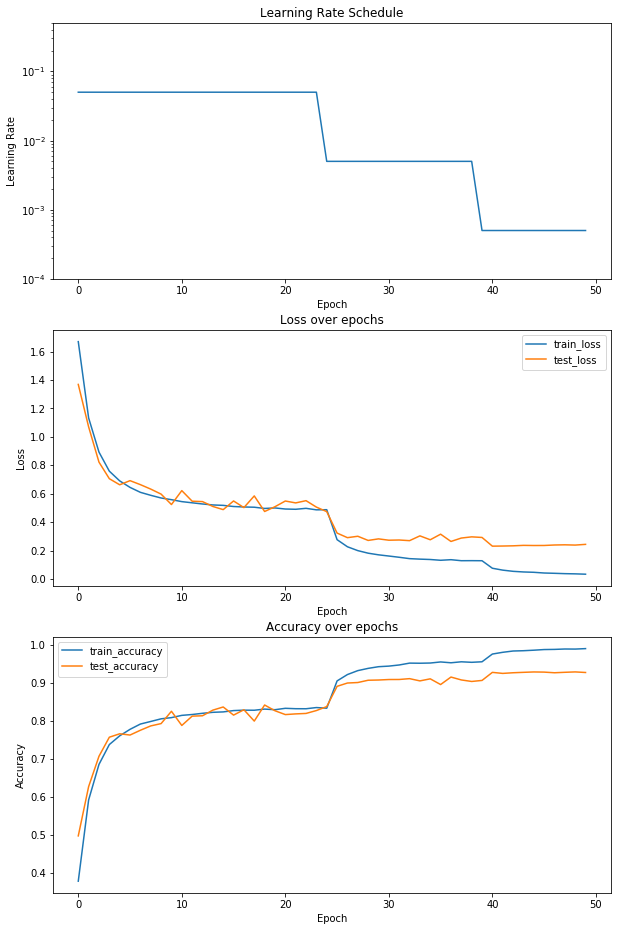

In [7]:
checkpoint = torch.load(f'{model_dir}_resnet9')
r9 = resnet9(num_classes=10)
r9.to(device)
r9.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r9, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])